# Importing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Definfing Variables

In [2]:
StartingTempMol = 283.15 #change this to Temp we are using
AirTemp= 277.55 # Air temperature in Kelvin
EndDistance= 135 # End distance in meters
TankRadi= 13.5 # Tank radius in meters
TankHeight= 15 # Tank height in meters
StartingVelMol= 100 #change this to velocity we are using
density = 1415 # Density in kg/m^3

# Initial conditions

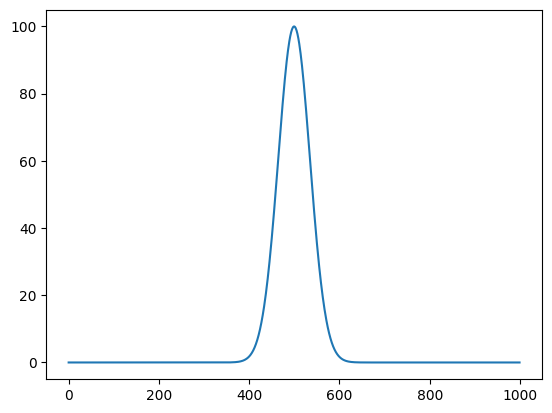

In [ ]:
# Spatial variables
N=1000 # Number of spatial steps
a=EndDistance/(N-1) # Size of a spatial node
indexToPos = np.arange(0,EndDistance+a,a) #Converts a 0-based index to a position in meters
def posToIndex(i): #Converts a position in meters to a 0-based index
    return int(np.floor(i/a))

# Temporal variables

h=0.01 # Time step in seconds

# Tracking position
hasMolasses = np.zeros(N,dtype=bool) # contains true if there is molasses at a given 
                                     # point, false otherwise
hasMolasses[0] = True # Initially, there is only molasses at the hole

# Viscosity equation
visc = np.zeros(N, dtype=np.float64)

# Make a gaussian function for testing
def g(x):
    return StartingVelMol * np.exp(-((x-EndDistance/2)**2/(EndDistance/3)))

# Velocity equation
vel = np.zeros(N, dtype=np.float64)
vel = np.vectorize(g)(indexToPos)
plt.plot(vel)

# Box of Functions

[550.51737063 552.51858844 554.30976229 555.88660813 557.24533897
 558.38268001 559.29588182 559.9827314  560.44156111 560.67125541
 560.67125541 560.44156111 559.9827314  559.29588182 558.38268001
 557.24533897 555.88660813 554.30976229 552.51858844 550.51737063]


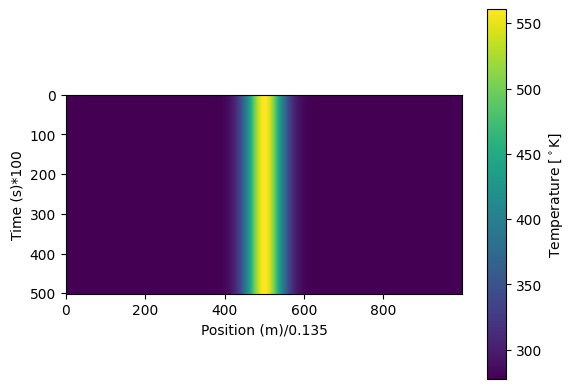

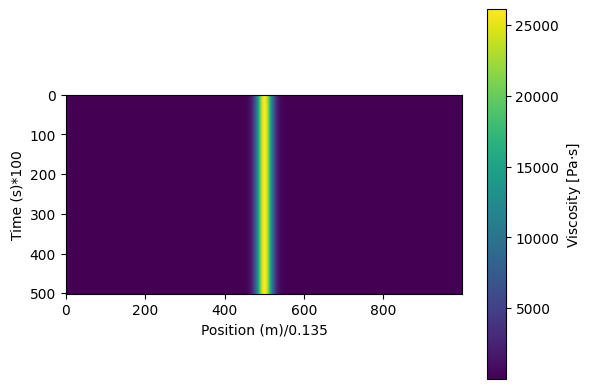

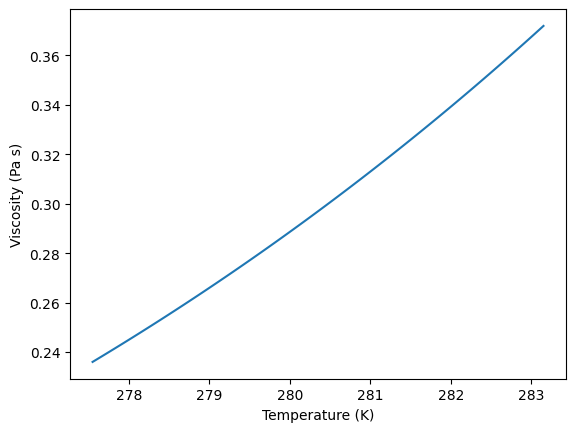

In [82]:
MAX_IND = 100   # Stores the maximum index that is filled with molasses. Will only be valid
                # in 1D.
xmax = 0

def xStep(): # Updates the molasses progress bar and the value MAX_IND which all other quantities depend on
    newmax = xmax
    for j in range(0,MAX_IND):
        v = vel[j]
        dx = v*h
        dind = posToIndex(dx)
        newmax = max(j + dind, newmax)
        for i in range(j+1, min(N-1, j + 1 + dind)):
            hasMolasses[i] = True
    newmax = min(N-2, newmax)
    
    return newmax, hasMolasses

#----------------- Heat Equation Below-----------------# 

c = h/(a*a) # Spatial step for solving 2nd order ODEs with FTCS

def alpha(T):
    k = 1.3e-3*T + 0.403
    return k/(2.56e3*1415)

def HeatStep(T):    
    Tp = np.zeros(len(T), dtype=np.float64)
    Tp[0] = AirTemp
    for i in range(1,len(T)-1):
        Tp[i] = T[i] + c*alpha(T[i])*(T[i+1]+T[i-1]-2*T[i])
    Tp[N-1] = AirTemp
    return Tp

t = 0
# Heat equation
# Make a gaussian heat function for testing
def gH(x):
    return StartingTempMol * np.exp(-((x-EndDistance/2)**2/(EndDistance/3)))
temp = np.full(N, AirTemp, dtype=np.float64) # Stores the temperature at the given index
dtemp = np.vectorize(gH)(indexToPos)
temp = temp + dtemp
temp[0] = StartingTempMol # At the hole, the molasses is the same temperature as in the tank
Tfull = []
Tfull.append(temp)
while(t < 5):
    temp = HeatStep(temp)
    Tfull.append(temp)
    t += h
print(Tfull[-1][int(N/2)-10:int(N/2)+10])
plt.imshow(Tfull)
plt.xlabel("Position (m)/0.135")
plt.ylabel("Time (s)*100")
plt.colorbar(label=r"Temperature [$^\circ$K]")
plt.savefig("TemperatureDemo.png")
plt.show()

#-----------------Viscosity Equation Below------------#

E0 = 53074.0 # J / mol
R = 8.314 # J/(K*mol)
mu0 = 2.3e9 # N*s/m^2

def ViscEQ(T):
    return mu0 * np.exp(-E0/(R*T))

viscarr = np.vectorize(ViscEQ)(Tfull)
plt.imshow(viscarr)
plt.xlabel("Position (m)/0.135")
plt.ylabel("Time (s)*100")
plt.colorbar(label=r"Viscosity [Pa$\cdot$s]")
plt.savefig("ViscosityDemo.png")
plt.show()

linT = np.linspace(AirTemp, StartingTempMol, 100)
visFunc = np.vectorize(ViscEQ)(linT)
plt.plot(linT, visFunc)
plt.xlabel("Temperature (K)")
plt.ylabel("Viscosity (Pa s)")
plt.savefig("ViscosityCurve.png")
plt.show()

#----------------Equation of Motion Below-------------#

# Note: Confined to 1 dimension, velocity is a scalar quantity, and gravity isn't a consideration



def velStep(v, T): # calculates the velocity at any position within any one timestep 
    
    muarr = ViscEQ(T)
    velp = v.copy()
    velp[0] = v[0]
    velp[1] = v[1]
    velp[2:N] = vel[2:N] + h/(density*a*a)*muarr[2:N]*(vel[2:N] + vel[0:N-2] - 2*vel[1:N-1]) - (
                    h * vel[2:N]*(vel[2:N]-vel[1:N-1])/(a))
    return velp

This next code cell should run all of the above functions in a while loop over N. This accounts for all spatial steps. I haven't yet figured out the specific architecture for this routine but if MAX_IND is updating properly, it should be easy enough. Those three lines at the bottom need to be there in order to update dind, MAX_IND, and hasMolasses, and need to occur in that specific order.

[ 90.26574004  91.41214448  92.50971272  93.55543904  94.54630361
  95.4792765   96.35132341  97.1594134   97.90052927  98.57168074
  99.16992079  99.69236512 100.13621473 100.49878148 100.77751601
 100.97003776 101.07416626 101.08795301 101.00971309 100.83805563]
[ 41.79759811  41.92769196  43.98530142  42.16723524  44.83950464
  48.99796668  31.66946104  73.05193272  10.5577768   80.55727802
  34.65024633  35.40715609  78.9252116   28.70837111  42.35570903
  96.14285235 -15.44286837 118.05137537   3.30347835  80.49944237]
[-3.22102741e+056 -3.96448413e+212  7.55581209e+211             -inf
             -inf             -inf             -inf             -inf
              nan              nan             -inf              nan
             -inf              nan              nan              nan
              nan              nan             -inf              nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan 

C:\Users\sethb\AppData\Local\Temp\ipykernel_32040\1060385562.py:91: RuntimeWarning: overflow encountered in multiply
  h * vel[2:N]*(vel[2:N]-vel[1:N-1])/(a))
C:\Users\sethb\AppData\Local\Temp\ipykernel_32040\1060385562.py:90: RuntimeWarning: invalid value encountered in add
  velp[2:N] = vel[2:N] + h/(density*a*a)*muarr[2:N]*(vel[2:N] + vel[0:N-2] - 2*vel[1:N-1]) - (
C:\Users\sethb\AppData\Local\Temp\ipykernel_32040\1060385562.py:90: RuntimeWarning: invalid value encountered in subtract
  velp[2:N] = vel[2:N] + h/(density*a*a)*muarr[2:N]*(vel[2:N] + vel[0:N-2] - 2*vel[1:N-1]) - (
C:\Users\sethb\AppData\Local\Temp\ipykernel_32040\1060385562.py:91: RuntimeWarning: invalid value encountered in subtract
  h * vel[2:N]*(vel[2:N]-vel[1:N-1])/(a))
C:\Users\sethb\AppData\Local\Temp\ipykernel_32040\1060385562.py:91: RuntimeWarning: overflow encountered in divide
  h * vel[2:N]*(vel[2:N]-vel[1:N-1])/(a))


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan

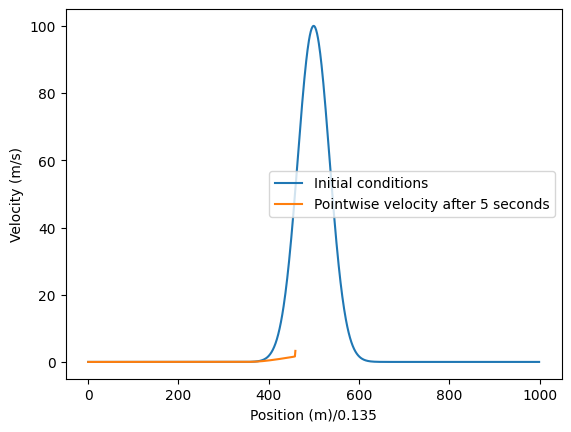

In [81]:
t = 0
iter = 0

vel = np.vectorize(g)(indexToPos)
vel0 = vel.copy()

# Make a gaussian heat function for testing
def gH(x):
    return StartingTempMol * np.exp(-((x-EndDistance/2)**2/(EndDistance/3)))
temp = np.full(N, AirTemp, dtype=np.float64) # Stores the temperature at the given index
dtemp = np.vectorize(gH)(indexToPos)
temp = temp + dtemp
temp[0] = StartingTempMol # At the hole, the molasses is the same temperature as in the tank


while t < 5:
    temp = HeatStep(temp)
    vel = velStep(vel, temp)

    t += h
    iter += 1

    if(iter % 10 == 1):
        print(vel[int(N/2)-10:int(N/2)+10])

print(vel[int(N/2)-10:int(N/2)+10])

plt.plot(vel0, label = "Initial conditions")
plt.plot(vel, label = "Pointwise velocity after 5 seconds")
plt.xlabel("Position (m)/0.135")
plt.ylabel("Velocity (m/s)")
plt.legend(loc = 'best')
plt.savefig("VelocityDemo.png")
plt.show()
    

This next code cell is the experimental 2D stuff I wanted to do. I haven't given up on it yet, but in the wake of revising the structure of the code I will need to re-evaluate how this function is meant to work.

In [ ]:
# The stuff below is experimental
# Trying to define a function that produces a 2D array of velocity values
# With each row representing velocity values at a particular timestep
# and each column representing a specific value in the simulation
# (i.e. all column 1 entries are at x meters, column 2 is at x + a, etc.)
# If this works we can do it for viscosity and temperature as well


def velMap(duration):

    dt = h

    t = 0

    velBox = [vel] # array of velocity arrays: each row is one timestep

    while t < duration:
        
        xStep()

        if MAX_IND > 2:
            newvel = velStep()
            velBox += [vel]
        
        t += dt
    
    return velBox
mpl.imshow(velMap(1),aspect="auto")
mpl.show()
    
